In [1]:
import gym
import highway_env
import numpy as np
import sys
import copy
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

random.seed(0)
np.random.seed(0)

# Hyperparameters

In [2]:
DEVICE = torch.device("cuda:5")
SAVE_DIR = "./saved"
SIGMA = 0.1
THETA = 0.1
BATCH_SIZE = 512
N_ITERS = 10000

# Models

In [3]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=SIGMA, theta=THETA, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir=SAVE_DIR):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        torch.nn.init.uniform_(self.q.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = DEVICE

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir=SAVE_DIR):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = DEVICE

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = torch.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=BATCH_SIZE):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + torch.tensor(self.noise(),
                                 dtype=torch.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = torch.tensor(reward, dtype=torch.float).to(self.critic.device)
        done = torch.tensor(done).to(self.critic.device)
        new_state = torch.tensor(new_state, dtype=torch.float).to(self.critic.device)
        action = torch.tensor(action, dtype=torch.float).to(self.critic.device)
        state = torch.tensor(state, dtype=torch.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = torch.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)

# Training loop

In [4]:
env = gym.make("parking-v0")
agent = Agent(alpha=0.000025, beta=0.00025, input_dims=[12], tau=0.001, env=env,
              batch_size=BATCH_SIZE,  layer1_size=400, layer2_size=300, n_actions=2)
score_history = []

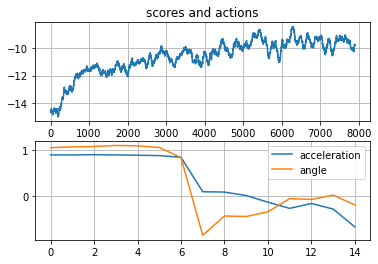

In [ ]:
for i in range(N_ITERS):
    actions1 = []
    actions2 = []
    done = False
    score = 0
    steps = 0
    state = env.reset()
    while not done:
        observation = list(state["observation"]) + list(state["desired_goal"])
        act = agent.choose_action(observation)
        state, reward, done, info = env.step(act)
        observation_new = list(state["observation"]) + list(state["desired_goal"])
        agent.remember(observation, act, reward, observation_new, int(done))
        agent.learn()
        score += reward
        obs = state
        actions1.append(act[0])
        actions2.append(act[1])
        
        steps += 1
        if steps > 30:
            done = True
    score_history.append(score)

    if i % 100 == 0:
        agent.save_models()
        
        clear_output(True)
        
        plt.subplot(2,1,1)
        plt.title("scores and actions")
        mean_scores = [np.mean(score_history[i:i+100]) for i in range(0, len(score_history) - 100)]
        plt.plot(mean_scores)
        plt.grid()
        
        plt.subplot(2,1,2)
        plt.plot(actions1)
        plt.plot(actions2)
        plt.legend(["acceleration","angle"])
        plt.grid()
        plt.savefig(f"{SAVE_DIR}/plots.png")
        plt.show()


In [ ]:
list(obs["observation"]) + list(obs["desired_goal"])

In [8]:
mean_scores

[]